In [1]:
# === 0. 基本設定（修改成你自己的路徑） ===
DATA_DIR = "data"
TRAIN_CSV = f"{DATA_DIR}/train.csv"
TEST_CSV  = f"{DATA_DIR}/test.csv"

TARGET = "SalePrice"

In [2]:
# === 1. 載入套件與資料 ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Microsoft JhengHei"  # Windows 常見中文字體
plt.rcParams["axes.unicode_minus"] = False  # 避免負號顯示成方框

train = pd.read_csv(TRAIN_CSV)
test  = pd.read_csv(TEST_CSV)

print("train shape:", train.shape)
print("test shape:", test.shape)
train.head(3)

train shape: (1460, 81)
test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
# === 2. 基本資訊與型態 ===
print("\n=== dtypes ===")
print(train.dtypes.value_counts())

print("\n=== info ===")
train.info()


=== dtypes ===
object     43
int64      35
float64     3
Name: count, dtype: int64

=== info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16

In [4]:
# === 3. 缺失值統計 ===
na_count = train.isnull().sum()
na_pct = (na_count / len(train)).sort_values(ascending=False)
na_table = pd.DataFrame({"NA_Count": na_count, "NA_%": na_pct}).sort_values("NA_%", ascending=False)
na_table.head(25)

,NA_Count,NA_%
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


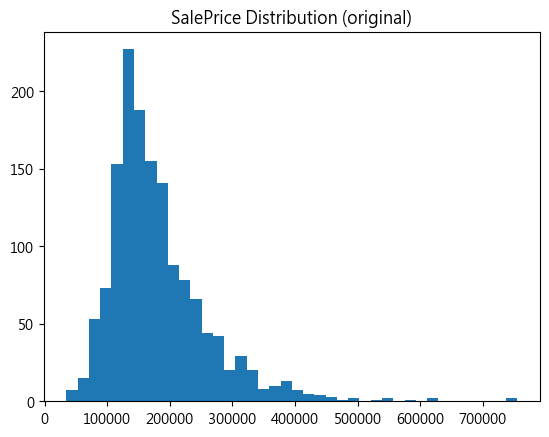

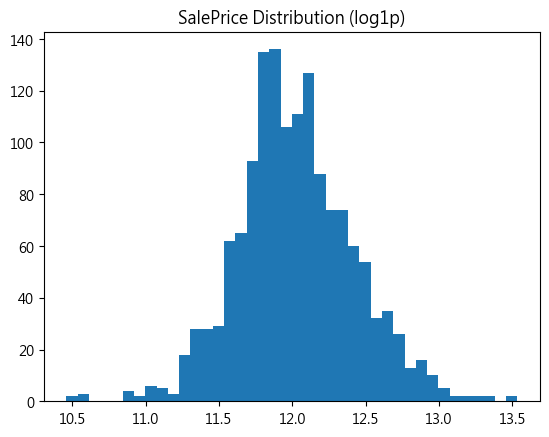

In [5]:
# === 4. 目標變數分布（原始與 log） ===
fig, ax = plt.subplots()
ax.hist(train[TARGET].dropna(), bins=40)
ax.set_title(f"{TARGET} Distribution (original)")
plt.show()

fig, ax = plt.subplots()
ax.hist(np.log1p(train[TARGET].dropna()), bins=40)
ax.set_title(f"{TARGET} Distribution (log1p)")
plt.show()

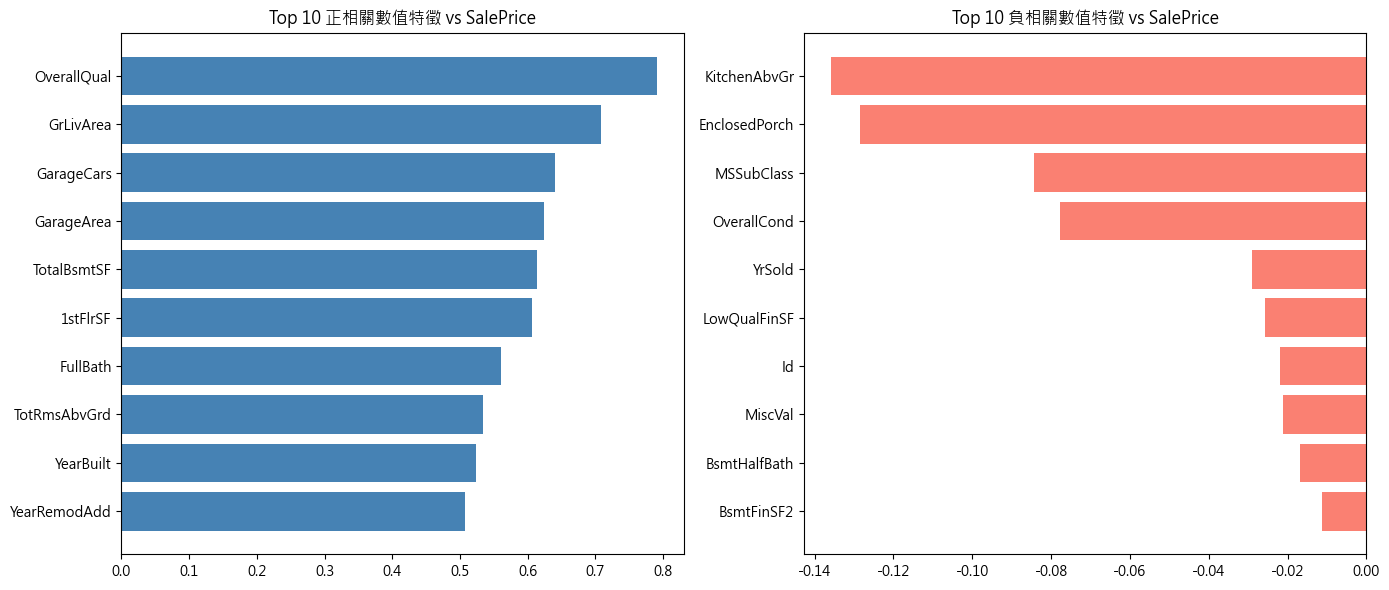

In [6]:
# === 5. 與 SalePrice 關聯最高的數值特徵 ===
# 計算相關性
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
corr_with_target = (
    train[numeric_cols].corr(numeric_only=True)[TARGET]
    .drop(TARGET).dropna()
)
# 正相關 Top 10
top_pos = corr_with_target.nlargest(10)
# 負相關 Top 10
top_neg = corr_with_target.nsmallest(10)

# 畫圖
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 正相關
axes[0].barh(top_pos.index[::-1], top_pos.values[::-1], color="steelblue")
axes[0].set_title(f"Top 10 正相關數值特徵 vs {TARGET}")

# 負相關
axes[1].barh(top_neg.index[::-1], top_neg.values[::-1], color="salmon")
axes[1].set_title(f"Top 10 負相關數值特徵 vs {TARGET}")

plt.tight_layout()
plt.show()

正相關 Top 4： ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']
負相關 Top 4： ['KitchenAbvGr', 'EnclosedPorch', 'MSSubClass', 'OverallCond']


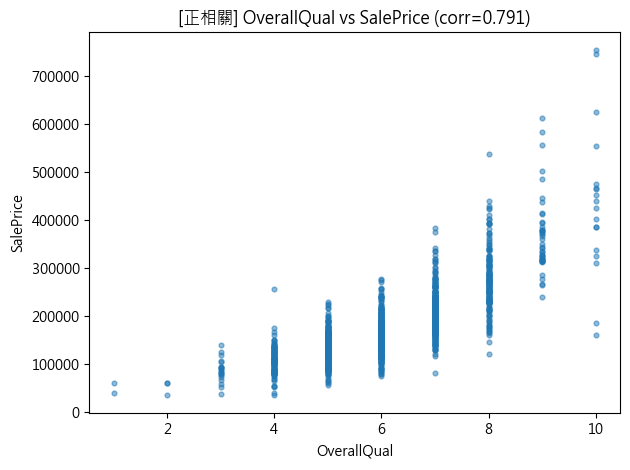

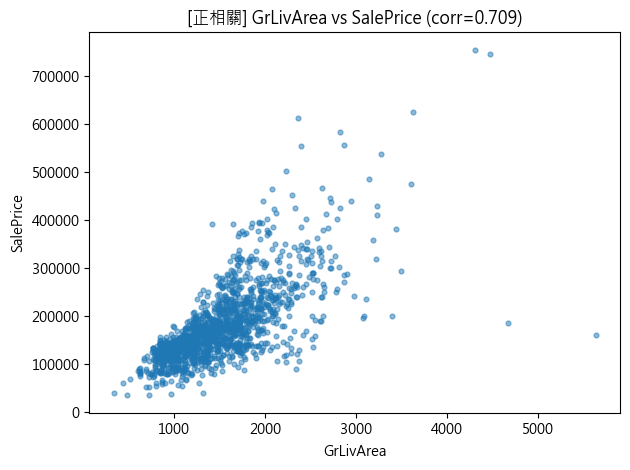

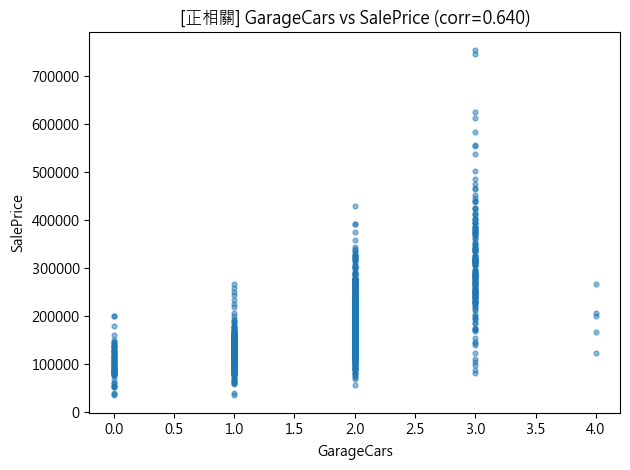

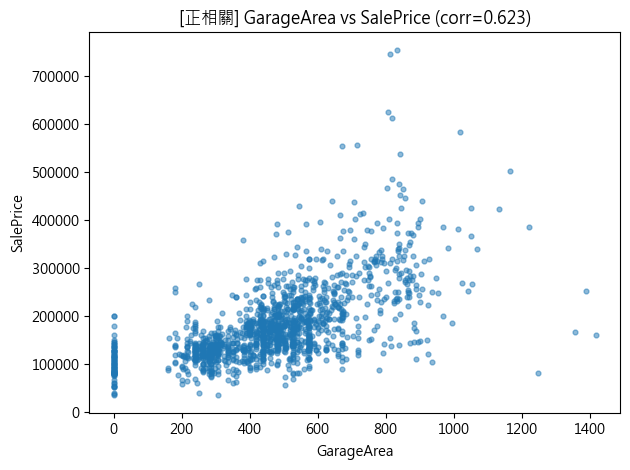

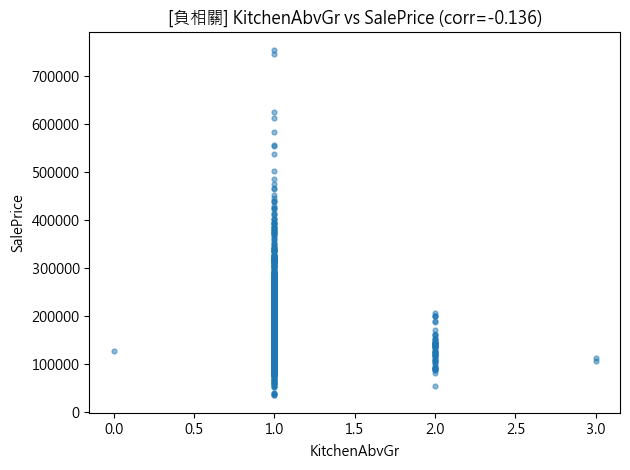

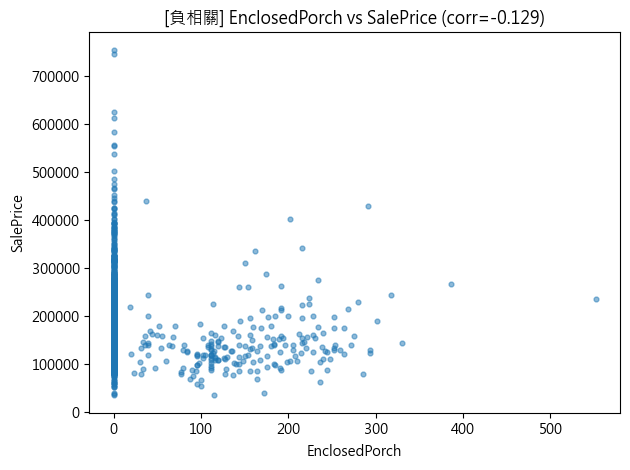

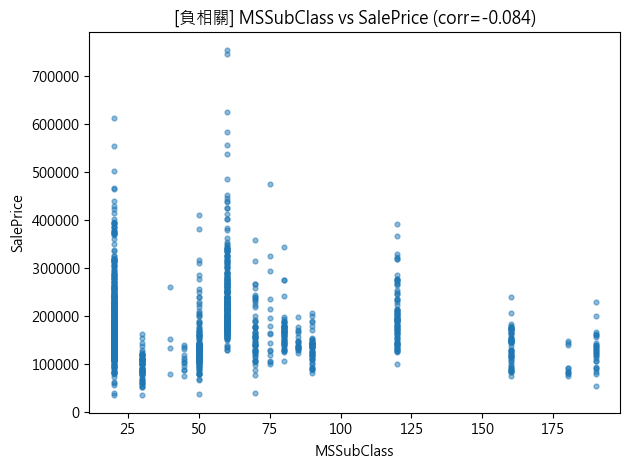

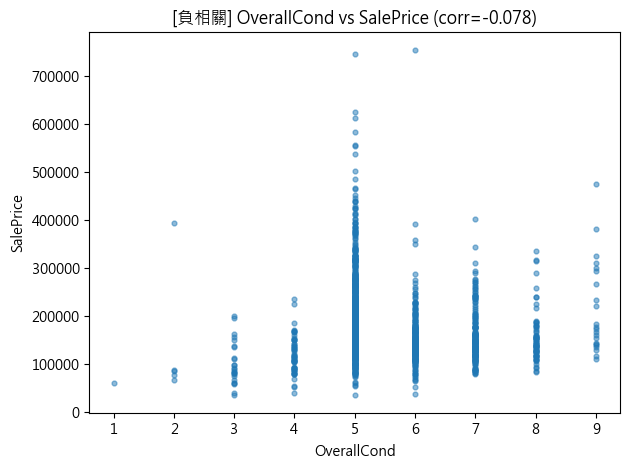

In [7]:
# === 6. 常見關鍵特徵散佈圖 ===
# 選前 4 個最相關的特徵
N = 4
top_pos_feats = corr_with_target.nlargest(N).index.tolist()
top_neg_feats = corr_with_target.nsmallest(N).index.tolist()

print(f"正相關 Top {N}：", top_pos_feats)
print(f"負相關 Top {N}：", top_neg_feats)

# 畫散點圖
def scatter_xy(df, x, y=TARGET, title=None):
    fig, ax = plt.subplots()
    # 只畫有資料的點
    d = df[[x, y]].dropna()
    ax.scatter(d[x], d[y], s=12, alpha=0.5)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(title or f"{x} vs {y}")
    plt.tight_layout()
    plt.show()

# 4) 依序繪製
for feat in top_pos_feats:
    scatter_xy(train, feat, TARGET, title=f"[正相關] {feat} vs {TARGET} (corr={corr_with_target[feat]:.3f})")

for feat in top_neg_feats:
    scatter_xy(train, feat, TARGET, title=f"[負相關] {feat} vs {TARGET} (corr={corr_with_target[feat]:.3f})")

In [8]:
"""
# === 7. 類別特徵與價格（以 Neighborhood 為例） ===
if "Neighborhood" in train.columns:
    med = train.groupby("Neighborhood")["SalePrice"].median().sort_values(ascending=False)
    print(med)

    topn = med.head(15)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(topn.index, topn.values)
    ax.set_title("Neighborhood Median SalePrice (Top 15)")
    ax.set_ylabel("Median SalePrice")
    plt.xticks(rotation=45)
    plt.show()
"""

'\n# === 7. 類別特徵與價格（以 Neighborhood 為例） ===\nif "Neighborhood" in train.columns:\n    med = train.groupby("Neighborhood")["SalePrice"].median().sort_values(ascending=False)\n    print(med)\n\n    topn = med.head(15)\n    fig, ax = plt.subplots(figsize=(10, 5))\n    ax.bar(topn.index, topn.values)\n    ax.set_title("Neighborhood Median SalePrice (Top 15)")\n    ax.set_ylabel("Median SalePrice")\n    plt.xticks(rotation=45)\n    plt.show()\n'